In [29]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra
using Plots
using ForwardDiff
using MeshCat

  Activating environment at `C:\Users\ameys\Desktop\Spring '24\16-745_OptimalControlAndRL\16-745_Flying_Acrobot\Project.toml`
Precompiling project...
  ✓ GPUArraysCore
  ✓ NBInclude
  ✓ ASL_jll
  ✓ METIS_jll
  ✓ OpenBLAS32_jll
  ✓ OpenSSL
  ✓ MUMPS_seq_jll
  ✓ StatsBase
  ✓ StructArrays
  ✓ FFMPEG_jll
  ✓ Ipopt_jll
  ✓ FFMPEG
  ✓ HTTP
  ✓ GR_jll
  ✓ GeometryBasics
  ✓ GR
  ✓ MeshCat
  ✓ MathOptInterface
  ✓ ECOS
  ✓ Plots
  ✓ Convex
  ✓ Ipopt
  22 dependencies successfully precompiled in 188 seconds (179 already precompiled)
  12 dependencies precompiled but different versions are currently loaded. Restart julia to access the new versions


In [30]:
#copied from RobotZoo src
function acrobot_dynamics(x, u)
    g = 9.81
    m1,m2 = [1.,1.]
    l1,l2 = [1.,1.]
    J1,J2 = [1.,1.]
    θ1,    θ2    = x[1], x[2]
    θ1dot, θ2dot = x[3], x[4]
    s1,c1 = sincos(θ1)
    s2,c2 = sincos(θ2)
    c12 = cos(θ1 + θ2)

    # mass matrix
    m11 = m1*l1^2 + J1 + m2*(l1^2 + l2^2 + 2*l1*l2*c2) + J2
    m12 = m2*(l2^2 + l1*l2*c2 + J2)
    m22 = l2^2*m2 + J2
    M = [m11 m12; m12 m22]

    # bias term
    tmp = l1*l2*m2*s2
    b1 = -(2 * θ1dot * θ2dot + θ2dot^2)*tmp
    b2 = tmp * θ1dot^2
    B = [b1, b2]

    # friction
    c = 1.0
    C = [c*θ1dot, c*θ2dot]

    # gravity term
    g1 = ((m1 + m2)*l2*c1 + m2*l2*c12) * g
    g2 = m2*l2*c12*g
    G = [g1, g2]

    # equations of motion
    τ = [0, u[1]]
    θddot = M\(τ - B - G - C)
    return [θ1dot, θ2dot, θddot[1], θddot[2]]
end

function dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = acrobot_dynamics(x, u)
    f2 = acrobot_dynamics(x + 0.5*h*f1, u)
    f3 = acrobot_dynamics(x + 0.5*h*f2, u)
    f4 = acrobot_dynamics(x + h*f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

dynamics_rk4 (generic function with 1 method)

In [31]:
function dfdx(x,u)
    ForwardDiff.jacobian(dx->dynamics_rk4(dx,u),x)
end

function dfdu(x,u)
    ForwardDiff.derivative(du->dynamics_rk4(x,du),u)
end

dfdu (generic function with 1 method)

In [32]:
h = 0.05 # time step 
Nx = 4     # number of state
Nu = 1     # number of controls
Tfinal = 10.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));

In [33]:
# Cost weights
Q = Diagonal([1.0*ones(2); 0.1*ones(2)]);
R = 0.01;
Qn = Array(100.0*I(Nx));

In [34]:
# cost formulation
function stage_cost(x,u)
    return 0.5*((x-xgoal)'*Q*(x-xgoal)) + 0.5*R*u*u
end

function terminal_cost(x)
    return 0.5*(x-xgoal)'*Qn*(x-xgoal)
end

function cost(xtraj,utraj)
    J = 0.0
    for k = 1:(Nt-1)
        J += stage_cost(xtraj[:,k],utraj[k])
    end
    J += terminal_cost(xtraj[:,Nt])
    return J
end

cost (generic function with 1 method)

In [35]:
#Initial guess
x0 = [-pi/2; 0; 0; 0]
xgoal = [-pi/4; pi/2; 0; 0]
xtraj = kron(ones(1,Nt), x0)
utraj = randn(Nt-1);

#Initial Rollout
for k = 1:(Nt-1)
    xtraj[:,k+1] .= dynamics_rk4(xtraj[:,k],utraj[k])
end
J = cost(xtraj,utraj)

465.3382708238227

In [36]:
#DDP Algorithm
using Printf
p = zeros(Nx,Nt)
P = zeros(Nx,Nx,Nt)
d = ones(Nt-1)
K = zeros(Nu,Nx,Nt-1)
ΔJ = 0.0

xn = zeros(Nx,Nt)
un = zeros(Nt-1)

gx = zeros(Nx)
gu = 0.0
Gxx = zeros(Nx,Nx)
Guu = 0.0
Gxu = zeros(Nx)
Gux = zeros(Nx)

iter = 0
while maximum(abs.(d[:])) > 1e-3
    iter += 1
    
    p = zeros(Nx,Nt)
    P = zeros(Nx,Nx,Nt)
    d = ones(Nt-1)
    K = zeros(Nu,Nx,Nt-1)
    ΔJ = 0.0

    p[:,Nt] = Qn*(xtraj[:,Nt]-xgoal)
    P[:,:,Nt] = Qn
    
    #Backward Pass
    for k = (Nt-1):-1:1
        #Calculate derivatives
        q = Q*(xtraj[:,k]-xgoal)
        r = R*utraj[k]
    
        A = dfdx(xtraj[:,k], utraj[k]) #ForwardDiff.jacobian(dx->dynamics_rk4(dx,utraj[k]),xtraj[:,k])
        B = dfdu(xtraj[:,k], utraj[k]) #ForwardDiff.derivative(du->dynamics_rk4(xtraj[:,k],du),utraj[k])
    
        gx = q + A'*p[:,k+1]
        gu = r + B'*p[:,k+1]
    
        Gxx = Q + A'*P[:,:,k+1]*A 
        Guu = R + B'*P[:,:,k+1]*B 
        Gxu = A'*P[:,:,k+1]*B 
        Gux = B'*P[:,:,k+1]*A
        
        d[k] = Guu\gu
        K[:,:,k] = Guu\Gux
    

        p[:,k] = gx - K[:,:,k]'*gu + K[:,:,k]'*Guu*d[k] - Gxu*d[k]
        P[:,:,k] = Gxx + K[:,:,k]'*Guu*K[:,:,k] - Gxu*K[:,:,k] - K[:,:,k]'*Gux
    
        ΔJ += gu'*d[k]
    end

    #Forward rollout with line search
    xn[:,1] = xtraj[:,1]
    α = 1.0
    for k = 1:(Nt-1)
        un[k] = utraj[k] - α*d[k] - dot(K[:,:,k],xn[:,k]-xtraj[:,k])
        xn[:,k+1] .= dynamics_rk4(xn[:,k],un[k])
    end
    Jn = cost(xn,un)
    
    while isnan(Jn) || Jn > (J - 1e-2*α*ΔJ)
        α = 0.5*α
        for k = 1:(Nt-1)
            un[k] = utraj[k] - α*d[k] - dot(K[:,:,k],xn[:,k]-xtraj[:,k])
            xn[:,k+1] = dynamics_rk4(xn[:,k],un[k])
        end
        Jn = cost(xn,un)
    end
    
    # logging
    if rem(iter - 1, 100) == 0
        @printf "iter     J           ΔJ        |d|         α       \n"
        @printf "---------------------------------------------------\n"
    end
    if rem(iter - 1, 10) == 0 
        @printf("%3d   %10.3e  %9.2e  %9.2e  %6.4f  \n",
              iter, J, ΔJ, maximum(abs.(d[:])), α)
    end
    
    J = Jn
    xtraj .= xn
    utraj .= un
end

iter     J           ΔJ        |d|         α       
---------------------------------------------------
  1    4.653e+02   3.92e+02   3.70e+01  1.0000  
 11    2.441e+02   3.10e-02   3.53e-01  1.0000  
 21    2.440e+02   4.45e-03   1.31e-01  1.0000  
 31    2.440e+02   9.76e-04   6.10e-02  1.0000  
 41    2.440e+02   2.40e-04   3.02e-02  1.0000  
 51    2.440e+02   6.18e-05   1.53e-02  1.0000  
 61    2.440e+02   1.62e-05   7.85e-03  1.0000  
 71    2.440e+02   4.29e-06   4.04e-03  1.0000  
 81    2.440e+02   1.14e-06   2.08e-03  1.0000  
 91    2.440e+02   3.03e-07   1.07e-03  1.0000  


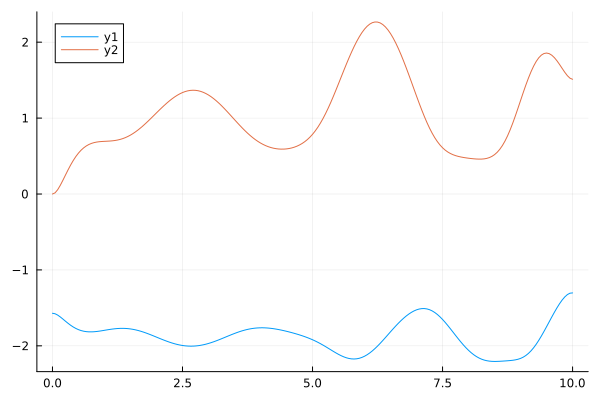

In [37]:
plot(thist,xtraj[1,:])
plot!(thist,xtraj[2,:])

In [40]:
# Acrobot (doublependulum)
using Colors
function build_acrobot!(vis, color=colorant"blue", thick=0.05)
    l1,l2 = [1.,1.]
    hinge = MeshCat.Cylinder(MeshCat.Point3f(-0.05,0,0), MeshCat.Point3f(0.05,0,0), 0.05f0)
    dim1  = MeshCat.Vec(thick, thick, l1)
    link1 = MeshCat.HyperRectangle(MeshCat.Vec(-thick/2,-thick/2,0),dim1)
    dim2  = MeshCat.Vec(thick, thick, l2)
    link2 = MeshCat.HyperRectangle(MeshCat.Vec(-thick/2,-thick/2,0),dim2)
    mat1 = MeshPhongMaterial(color=colorant"grey")
    mat2 = MeshPhongMaterial(color=color)
    setobject!(vis["base"], hinge, mat1) 
    setobject!(vis["link1"], link1, mat2) 
    setobject!(vis["link1","joint"], hinge, mat1) 
    setobject!(vis["link1","link2"], link2, mat2) 
    settransform!(vis["link1","link2"], MeshCat.Translation(0,0,l1))
    settransform!(vis["link1","joint"], MeshCat.Translation(0,0,l1))
end

function RotX(alpha)
    c, s = cos(alpha), sin(alpha)
    [1 0 0; 0 c -s; 0 s  c]
end
function update_acro_pose!(vis, x)
    l1, l2 = [1, 1.]
    settransform!(vis["robot","link1"], MeshCat.LinearMap(RotX(x[1]-pi/2)))
    settransform!(vis["robot","link1","link2"], MeshCat.compose(MeshCat.Translation(0,0,l1), MeshCat.LinearMap(RotX(x[2]))))
end

update_acro_pose! (generic function with 1 method)

In [41]:
vis = Visualizer()
build_acrobot!(vis["robot"])
anim = MeshCat.Animation(floor(Int, 1 / h))
for k = 1:Nt
    MeshCat.atframe(anim, k) do
        update_acro_pose!(vis, xtraj[:,k])
    end
end
MeshCat.setanimation!(vis, anim)
render(vis)

[ Info: Listening on: 127.0.0.1:8706, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8706


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x62, 0x61, 0x73, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "link1" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x31], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("joint" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "link2" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x32], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8706))